In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/ms_singlecell/data

HD_ABT_filtered.h5ad   PMS_ABT_filtered.h5ad
HD_DMSO_filtered.h5ad  PMS_DMSO_filtered.h5ad


In [3]:
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 112.9 MB/s eta 0:00:00


In [4]:
import scanpy as sc

base = "/content/drive/MyDrive/ms_singlecell/data"

adata_pms_abt  = sc.read_h5ad(f"{base}/PMS_ABT_filtered.h5ad")
adata_pms_dmso = sc.read_h5ad(f"{base}/PMS_DMSO_filtered.h5ad")
adata_hd_abt   = sc.read_h5ad(f"{base}/HD_ABT_filtered.h5ad")
adata_hd_dmso  = sc.read_h5ad(f"{base}/HD_DMSO_filtered.h5ad")

In [5]:
for name, ad in {
    "PMS_ABT": adata_pms_abt,
    "PMS_DMSO": adata_pms_dmso,
    "HD_ABT": adata_hd_abt,
    "HD_DMSO": adata_hd_dmso,
}.items():
    print(name, ad.shape)

PMS_ABT (8987, 60623)
PMS_DMSO (3281, 60623)
HD_ABT (11424, 60623)
HD_DMSO (9331, 60623)


In [6]:
#check mathematical space
import numpy as np

print("DMSO shape:", adata_pms_dmso.shape)
print("ABT shape :", adata_pms_abt.shape)

# Check gene identity and order
same_genes = np.array_equal(adata_pms_dmso.var_names, adata_pms_abt.var_names)
print("Genes identical and aligned:", same_genes)

DMSO shape: (3281, 60623)
ABT shape : (8987, 60623)
Genes identical and aligned: True


In [7]:
print("DMSO X type:", type(adata_pms_dmso.X))
print("ABT  X type:", type(adata_pms_abt.X))

DMSO X type: <class 'scipy.sparse._csr.csr_matrix'>
ABT  X type: <class 'scipy.sparse._csr.csr_matrix'>


In [8]:
print("DMSO min/max:", adata_pms_dmso.X.min(), adata_pms_dmso.X.max())
print("ABT  min/max:", adata_pms_abt.X.min(), adata_pms_abt.X.max())

DMSO min/max: 0.0 1862.0
ABT  min/max: 0.0 1273.0


In [9]:
import numpy as np

# Total RNA counts per cell
libsize_dmso = np.array(adata_pms_dmso.X.sum(axis=1)).flatten()
libsize_abt  = np.array(adata_pms_abt.X.sum(axis=1)).flatten()

print("DMSO mean total counts per cell:", libsize_dmso.mean())
print("ABT  mean total counts per cell:", libsize_abt.mean())

print("DMSO median:", np.median(libsize_dmso))
print("ABT  median:", np.median(libsize_abt))

DMSO mean total counts per cell: 13764.217
ABT  mean total counts per cell: 10733.3545
DMSO median: 6624.0
ABT  median: 9615.0


In [10]:
# Number of genes detected (non-zero) per cell
genes_dmso = np.array((adata_pms_dmso.X > 0).sum(axis=1)).flatten()
genes_abt  = np.array((adata_pms_abt.X > 0).sum(axis=1)).flatten()

print("DMSO mean genes per cell:", genes_dmso.mean())
print("ABT  mean genes per cell:", genes_abt.mean())

print("DMSO median genes:", np.median(genes_dmso))
print("ABT  median genes:", np.median(genes_abt))

DMSO mean genes per cell: 3433.1837854312707
ABT  mean genes per cell: 3399.001112718371
DMSO median genes: 2411.0
ABT  median genes: 3413.0


In [11]:
import scanpy as sc

# Work on copies (important)
adata_dmso_n = adata_pms_dmso.copy()
adata_abt_n  = adata_pms_abt.copy()

# Normalize per cell
sc.pp.normalize_total(adata_dmso_n, target_sum=1e4)
sc.pp.normalize_total(adata_abt_n,  target_sum=1e4)

# Log-transform
sc.pp.log1p(adata_dmso_n)
sc.pp.log1p(adata_abt_n)

In [12]:
# Filter genes expressed in at least 10 cells
sc.pp.filter_genes(adata_dmso_n, min_cells=10)
sc.pp.filter_genes(adata_abt_n,  min_cells=10)

print("Genes after filtering (DMSO):", adata_dmso_n.n_vars)
print("Genes after filtering (ABT):",  adata_abt_n.n_vars)

Genes after filtering (DMSO): 23750
Genes after filtering (ABT): 27165


In [13]:
common_genes = adata_dmso_n.var_names.intersection(adata_abt_n.var_names)

print("Common genes after filtering:", len(common_genes))

Common genes after filtering: 23494


In [14]:
adata_dmso_n = adata_dmso_n[:, common_genes].copy()
adata_abt_n  = adata_abt_n[:,  common_genes].copy()

print("DMSO genes:", adata_dmso_n.n_vars)
print("ABT  genes:", adata_abt_n.n_vars)

DMSO genes: 23494
ABT  genes: 23494


In [15]:
sc.pp.highly_variable_genes(
    adata_dmso_n,
    n_top_genes=2000,
    flavor="cell_ranger"
)

sc.pp.highly_variable_genes(
    adata_abt_n,
    n_top_genes=2000,
    flavor="cell_ranger"
)

In [16]:
hvg_common = (
    adata_dmso_n.var["highly_variable"] &
    adata_abt_n.var["highly_variable"]
)

print("Shared HVGs:", hvg_common.sum())
print("Mask length:", len(hvg_common))
print("Gene count:", adata_dmso_n.n_vars)

Shared HVGs: 616
Mask length: 23494
Gene count: 23494


In [17]:
adata_dmso_hvg = adata_dmso_n[:, hvg_common].copy()
adata_abt_hvg  = adata_abt_n[:,  hvg_common].copy()

print("DMSO shape:", adata_dmso_hvg.shape)
print("ABT  shape:", adata_abt_hvg.shape)

DMSO shape: (3281, 616)
ABT  shape: (8987, 616)


In [18]:
import scanpy as sc

# Run PCA separately on the HVG-restricted data
sc.tl.pca(
    adata_dmso_hvg,
    n_comps=30,
    svd_solver="arpack"
)

sc.tl.pca(
    adata_abt_hvg,
    n_comps=30,
    svd_solver="arpack"
)

In [19]:
print("DMSO variance explained (first 10 PCs):")
print(adata_dmso_hvg.uns["pca"]["variance_ratio"][:10])

print("\nABT variance explained (first 10 PCs):")
print(adata_abt_hvg.uns["pca"]["variance_ratio"][:10])

DMSO variance explained (first 10 PCs):
[0.17759858 0.04306281 0.03953712 0.02262408 0.02084019 0.01500296
 0.01255195 0.01172909 0.01068541 0.00934565]

ABT variance explained (first 10 PCs):
[0.09912313 0.05249671 0.04328046 0.02237359 0.01801784 0.01713972
 0.01615052 0.0121189  0.01114232 0.01018545]


In [20]:
# Keep first 20 PCs for geometry
X_dmso_20 = adata_dmso_hvg.obsm["X_pca"][:, :20]
X_abt_20  = adata_abt_hvg.obsm["X_pca"][:, :20]

print(X_dmso_20.shape, X_abt_20.shape)

(3281, 20) (8987, 20)


In [21]:
import numpy as np

np.random.seed(0)

# Choose number of cells
n_sample = 1000

# Random subsampling
idx_dmso = np.random.choice(X_dmso_20.shape[0], n_sample, replace=False)
idx_abt  = np.random.choice(X_abt_20.shape[0],  n_sample, replace=False)

X_dmso_sub = X_dmso_20[idx_dmso]
X_abt_sub  = X_abt_20[idx_abt]

In [22]:
from scipy.spatial.distance import pdist, squareform

# Compute RDMs
RDM_dmso = squareform(pdist(X_dmso_sub, metric="euclidean"))
RDM_abt  = squareform(pdist(X_abt_sub,  metric="euclidean"))

print(RDM_dmso.shape, RDM_abt.shape)

(1000, 1000) (1000, 1000)


In [23]:
def local_compactness(RDM, k=10):
    # Sort distances for each cell
    sorted_dists = np.sort(RDM, axis=1)
    # Skip the first column (distance to itself = 0)
    return np.mean(sorted_dists[:, 1:k+1])

In [24]:
comp_dmso = local_compactness(RDM_dmso, k=10)
comp_abt  = local_compactness(RDM_abt,  k=10)

print("DMSO compactness:", comp_dmso)
print("ABT  compactness:", comp_abt)

DMSO compactness: 3.73996670241681
ABT  compactness: 4.126320228013191


In [25]:
def global_dispersion(RDM):
    # Use upper triangle only (avoid duplicates)
    triu = RDM[np.triu_indices_from(RDM, k=1)]
    return np.mean(triu)

In [26]:
disp_dmso = global_dispersion(RDM_dmso)
disp_abt  = global_dispersion(RDM_abt)

print("DMSO dispersion:", disp_dmso)
print("ABT  dispersion:", disp_abt)

DMSO dispersion: 9.046809492679897
ABT  dispersion: 8.686471543603497


In [27]:
def distance_stats(RDM):
    triu = RDM[np.triu_indices_from(RDM, k=1)]
    return np.mean(triu), np.std(triu)

mean_dmso, std_dmso = distance_stats(RDM_dmso)
mean_abt,  std_abt  = distance_stats(RDM_abt)

print("DMSO mean/std:", mean_dmso, std_dmso)
print("ABT  mean/std:", mean_abt,  std_abt)

DMSO mean/std: 9.046809492679897 3.0230052842709054
ABT  mean/std: 8.686471543603497 2.2507286128977335


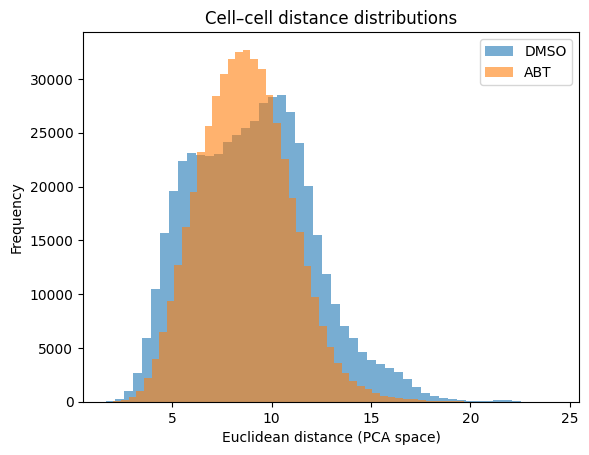

In [28]:
import matplotlib.pyplot as plt

# Extract upper-triangle distances
d_dmso = RDM_dmso[np.triu_indices_from(RDM_dmso, k=1)]
d_abt  = RDM_abt[np.triu_indices_from(RDM_abt,  k=1)]

plt.figure()
plt.hist(d_dmso, bins=50, alpha=0.6, label="DMSO")
plt.hist(d_abt,  bins=50, alpha=0.6, label="ABT")
plt.xlabel("Euclidean distance (PCA space)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Cell–cell distance distributions")
plt.show()

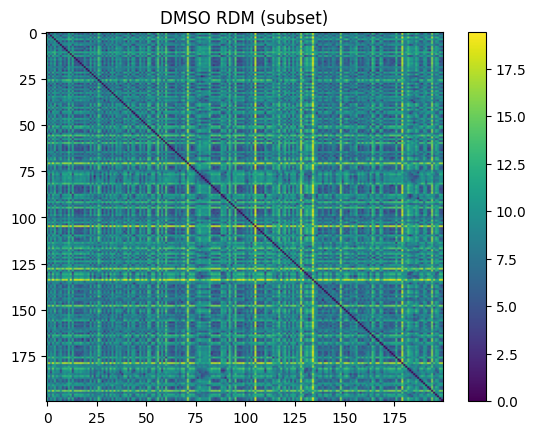

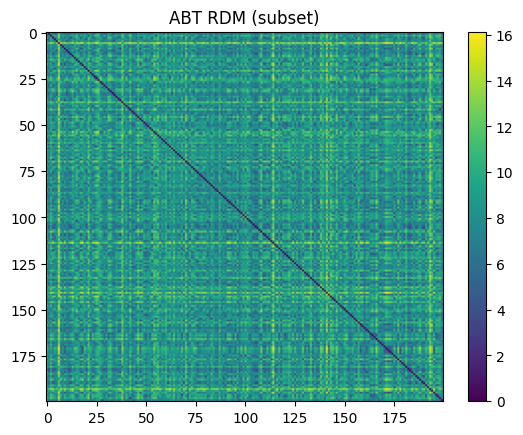

In [29]:
plt.figure()
plt.imshow(RDM_dmso[:200, :200], aspect="auto")
plt.colorbar()
plt.title("DMSO RDM (subset)")
plt.show()

plt.figure()
plt.imshow(RDM_abt[:200, :200], aspect="auto")
plt.colorbar()
plt.title("ABT RDM (subset)")
plt.show()